# FLEX

This notebook runs [GOTM](https://gotm.net/) using the [FLEX](https://gotm.net/cases/flex/) test case. 


In [1]:
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../../../gotmtool")
from gotmtool import *

## Create a model
Create a model with environment file `../../.gotm_env.yaml`, which is created by `gotm_env_init.py`. 

In [2]:
m = Model(name='FLEX', environ='../../.gotm_env.yaml')

Take a look at what are defined in the environment file.

In [3]:
for key in m.environ:
    print('{:>15s}: {}'.format(key, m.environ[key]) )

   gotmdir_code: /Users/qingli/develop/cvmix_in_gotm/gotm/code
   gotmdir_data: /Users/qingli/develop/cvmix_in_gotm/gotm/data
  gotmdir_build: /Users/qingli/develop/cvmix_in_gotm/gotm/build
    gotmdir_exe: /Users/qingli/develop/cvmix_in_gotm/gotm/exe
    gotmdir_run: /Users/qingli/develop/cvmix_in_gotm/gotm/run
 gotmdir_figure: /Users/qingli/develop/cvmix_in_gotm/gotm/figure
   gotmdir_tool: /Users/qingli/develop/cvmix_in_gotm/gotmtool


## Build the model

In [4]:
%%time
m.build()

CPU times: user 3.61 ms, sys: 9.04 ms, total: 12.7 ms
Wall time: 79.9 ms


## Configuration
Initialize the GOTM configuration

In [5]:
cfg = m.init_config()

Generating default configuration at '/Users/qingli/develop/cvmix_in_gotm/gotm/run/FLEX/gotm.yaml'...
Done!


Update the configuration

In [6]:
# setup
title = 'FLEX'
nlev = 145
cfg['title'] = title
cfg['location']['name'] = 'Flex Experiment 1976'
cfg['location']['latitude'] = 58.92
cfg['location']['longitude'] = 0.32
cfg['location']['depth'] = 145.0
cfg['time']['start'] = '1976-04-06 06:00:00'
cfg['time']['stop']  = '1976-06-07 00:00:00'
cfg['time']['dt']    = 360.0
cfg['grid']['nlev']  = nlev

# output
cfg['output']['gotm_out']['title'] = title
cfg['output']['gotm_out']['k1_stop'] = nlev+1
cfg['output']['gotm_out']['k_stop'] = nlev
cfg['output']['gotm_out']['time_unit'] = 'dt'
cfg['output']['gotm_out']['time_step'] = 30

# forcing
datadir = m.environ['gotmdir_data']+'/FLEX'
cfg['temperature']['method'] = 2
cfg['temperature']['file'] = datadir+'/t_prof_file.dat'
cfg['salinity']['method'] = 2
cfg['salinity']['file'] = datadir+'/s_prof_file.dat'
cfg['salinity']['relax']['tau'] = 172800.0
cfg['salinity']['relax']['tau_s'] = 172800.0
cfg['salinity']['relax']['tau_b'] = 72800.0
cfg['surface']['fluxes']['method'] = 0
cfg['surface']['fluxes']['heat']['method'] = 2
cfg['surface']['fluxes']['heat']['file'] = datadir+'/heatflux_file.dat'
cfg['surface']['fluxes']['tx']['method'] = 2
cfg['surface']['fluxes']['tx']['file'] = datadir+'/momentumflux_file.dat'
cfg['surface']['fluxes']['tx']['column'] = 1
cfg['surface']['fluxes']['ty']['method'] = 2
cfg['surface']['fluxes']['ty']['file'] = datadir+'/momentumflux_file.dat'
cfg['surface']['fluxes']['ty']['column'] = 2
cfg['surface']['meteo']['swr']['method'] = 2
cfg['surface']['meteo']['swr']['file'] = datadir+'/swr_file.dat'
cfg['surface']['sst']['method'] = 2
cfg['surface']['sst']['file'] = datadir+'/sst_file.dat'

# water type
cfg['light_extinction']['method'] = 7
cfg['light_extinction']['A']['method'] = 2
cfg['light_extinction']['A']['file'] = datadir+'/extinct_file.dat'
cfg['light_extinction']['A']['column'] = 1
cfg['light_extinction']['g1']['method'] = 2
cfg['light_extinction']['g1']['file'] = datadir+'/extinct_file.dat'
cfg['light_extinction']['g1']['column'] = 2
cfg['light_extinction']['g2']['method'] = 2
cfg['light_extinction']['g2']['file'] = datadir+'/extinct_file.dat'
cfg['light_extinction']['g2']['column'] = 3

# EOS 
cfg['eq_state']['mode'] = 1
cfg['eq_state']['method'] = 2

# buoyancy
cfg['buoyancy']['NN_ini'] = 1.0e-4

We want to run the case using two turbulence closure methods:
- The generic length scale (GLS; [Umlauf and Burchard, 2003](https://doi.org/10.1357/002224003322005087)) model in the $k$-$\epsilon$ formulation with the weak-equilibrium stability function by [Canuto et al., 2001](https://doi.org/10.1175/1520-0485(2001)031%3C1413:OTPIOP%3E2.0.CO;2) (C01A).
- The K-profile parameterization (KPP; [Large et al., 1994](https://doi.org/10.1029/94RG01872), [Griffies et al., 2015](https://github.com/CVMix/CVMix-description/raw/master/cvmix.pdf)) with [CVMix](http://cvmix.github.io).


In [7]:
# collect the configurations and the labels of the two runs
cfgs = []
labels = []

In [8]:
cfg['turbulence']['turb_method'] = 3
cfg['turbulence']['tke_method'] = 2
cfg['turbulence']['len_scale_method'] = 10
cfg['turbulence']['scnd']['method'] =  2
cfg['turbulence']['scnd']['scnd_coeff'] =  5
cfg['turbulence']['turb_param']['length_lim'] = 'true'
cfg['turbulence']['turb_param']['compute_c3'] = 'true'
cfg['turbulence']['turb_param']['galp'] = 0.53
cfg['turbulence']['generic']['gen_m'] = 1.5 
cfg['turbulence']['generic']['gen_n'] = -1.0
cfg['turbulence']['generic']['gen_p'] = 3.0 
cfg['turbulence']['generic']['cpsi1'] = 1.44
cfg['turbulence']['generic']['cpsi2'] = 1.92
cfg['turbulence']['generic']['cpsi3minus'] = -0.63
cfg['turbulence']['generic']['cpsi3plus'] = 1.0 
cfg['turbulence']['generic']['sig_kpsi'] = 1.0 
cfg['turbulence']['generic']['sig_psi'] = 1.3
cfgs.append(copy.deepcopy(cfg))
labels.append('GLS-C01A')

In [9]:
cfg['turbulence']['turb_method'] = 100
cfgs.append(copy.deepcopy(cfg))
labels.append('KPP-CVMix')

## Run the model

In [10]:
%%time
sims = m.run_batch(configs=cfgs, labels=labels, nproc=2)

CPU times: user 11.4 ms, sys: 13.7 ms, total: 25.1 ms
Wall time: 2.58 s


## Results

Load the data into an `xarray.Dataset`.

(-100, 0)

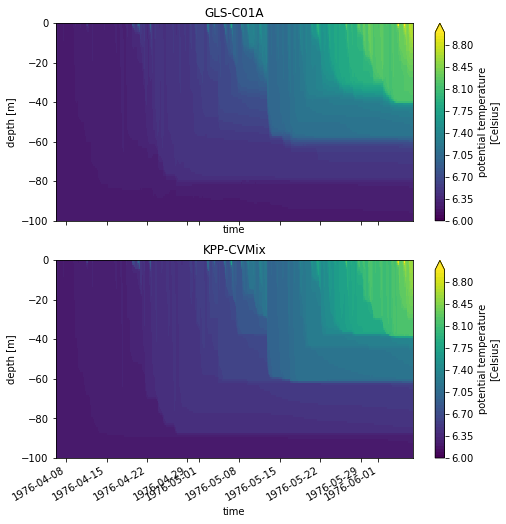

In [11]:
fig, axarr = plt.subplots(2, sharex='col')
fig.set_size_inches(8, 8)
data0 = sims[0].load_data()
levels = np.linspace(6, 9, 61)
data0.temp.plot(ax=axarr[0], levels=levels)
axarr[0].set_title(labels[0])
axarr[0].set_ylim([-100, 0])
data1 = sims[1].load_data()
data1.temp.plot(ax=axarr[1], levels=levels)
axarr[1].set_title(labels[1])
axarr[1].set_ylim([-100, 0])